In [29]:
%matplotlib inline


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# verify data
%ls drive/MyDrive/training_data/quadrant_enumeration/

coco_quadrant_enumeration_2048_1024.json  masks_teeth_2048_1024/           xrays_2048_1024/
coco_quadrant_enumeration_2048_2048.json  masks_teeth_2048_2048/           xrays_2048_2048/
masks_quadrant_2048_1024/                 train_quadrant_enumeration.json  yolo_2048_2048/
masks_quadrant_2048_2048/                 xrays/


In [4]:
!nvidia-smi

Fri Dec  6 17:28:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=33):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        def up_block(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.encoder1 = conv_block(in_channels, 64)
        self.encoder2 = conv_block(64, 128)
        self.encoder3 = conv_block(128, 256)
        self.encoder4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = up_block(1024, 512)
        self.decoder4 = conv_block(1024, 512)
        self.upconv3 = up_block(512, 256)
        self.decoder3 = conv_block(512, 256)
        self.upconv2 = up_block(256, 128)
        self.decoder2 = conv_block(256, 128)
        self.upconv1 = up_block(128, 64)
        self.decoder1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))

        bottleneck = self.bottleneck(self.pool(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = self.decoder4(torch.cat((dec4, enc4), dim=1))
        dec3 = self.upconv3(dec4)
        dec3 = self.decoder3(torch.cat((dec3, enc3), dim=1))
        dec2 = self.upconv2(dec3)
        dec2 = self.decoder2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.decoder1(torch.cat((dec1, enc1), dim=1))

        return self.final_conv(dec1)


In [44]:
import os
import json
from PIL import Image, ImageDraw
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms import functional as TF

class ToothSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, coco_json, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        with open(coco_json, "r") as f:
            coco_data = json.load(f)

        # Group annotations by image_id
        self.image_info = {img["id"]: img for img in coco_data["images"]}
        self.image_annotations = {img_id: [] for img_id in self.image_info.keys()}
        for annotation in coco_data["annotations"]:
            self.image_annotations[annotation["image_id"]].append(annotation)

        # Use only image IDs for indexing
        self.image_ids = list(self.image_info.keys())
        print(f"Dataset initialized with {len(self.image_ids)} images.")

    def __getitem__(self, index):
        # print(f"getting item {index}")
        image_id = self.image_ids[index]
        image_name = self.image_info[image_id]["file_name"]
        image_path = os.path.join(self.image_dir, image_name)

        # Load image
        image = Image.open(image_path).convert("L")  # Grayscale

        # Create composite mask
        mask = Image.new("L", image.size, 0)  # Start with a blank mask
        draw = ImageDraw.Draw(mask)
        for annotation in self.image_annotations[image_id]:
            points = np.array(annotation["segmentation"]).reshape(-1, 2)
            draw.polygon([tuple(p) for p in points], fill=annotation["category_id"])

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

    def __len__(self):
        return len(self.image_ids)


def transform(image, mask):
    image = TF.resize(image, (256, 256))
    mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST)
    image = TF.to_tensor(image)
    mask = torch.from_numpy(np.array(mask, dtype=np.int64))  # Convert to tensor
    return image, mask


In [69]:

class DiceLoss(nn.Module):
    def __init__(self, weights=None):
        """
        DiceLoss with optional class weights.

        Args:
            weights (torch.Tensor): Weights for each class. Shape: (num_classes,)
        """
        super(DiceLoss, self).__init__()
        self.weights = weights

    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)  # Class probabilities
        target = F.one_hot(target, num_classes=33).permute(0, 3, 1, 2).float()  # One-hot encode target

        intersection = (pred * target).sum(dim=(2, 3))  # Per class intersection
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))  # Per class union

        dice_score = 2.0 * intersection / (union + 1e-6)  # Per class Dice score

        # Apply weights
        if self.weights is not None:
            dice_score = dice_score * self.weights.view(1, -1)

        return 1.0 - dice_score.mean()  # Mean weighted Dice loss


def dice_metric(pred, target, num_classes=33):
    """
    Compute per-class Dice scores.
    """
    pred = torch.argmax(pred, dim=1)  # Shape: (batch_size, H, W)
    dice_scores = []

    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()

        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()

        if union == 0:  # Avoid NaN for empty classes
            dice_scores.append(torch.tensor(1.0))  # Perfect score for empty classes
        else:
            dice_scores.append((2.0 * intersection) / (union + 1e-6))

    return dice_scores







In [70]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

def train_unet(model, train_loader, val_loader, epochs, device, weights):
    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=1e-3)
    # criterion = DiceLoss(weights=weights.to(device))

    # Use CrossEntropyLoss with optional weights
    if weights is not None:
        weights = weights.to(device)
        criterion = CrossEntropyLoss(weight=weights)
    else:
        criterion = CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

        # Validation step
        model.eval()
        with torch.no_grad():
            all_dice_scores = {c: [] for c in range(33)}
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                per_class_dice = dice_metric(outputs, masks)
                for c, score in enumerate(per_class_dice):
                    all_dice_scores[c].append(score)

        mean_dice_scores = {c: sum(scores) / len(scores) for c, scores in all_dice_scores.items()}
        print(f"Epoch {epoch + 1}/{epochs}, Per-Class Dice Scores: {mean_dice_scores}")
        overall_dice = sum(mean_dice_scores.values()) / len(mean_dice_scores)
        print(f"Epoch {epoch + 1}/{epochs}, Overall Val Dice Score: {overall_dice:.4f}")



In [76]:
# Paths
base_dir = "drive/MyDrive/training_data/quadrant_enumeration"
image_dir = os.path.join(base_dir, "xrays_2048_1024")
mask_dir = os.path.join(base_dir, "masks_teeth_2048_1024")
coco_json = os.path.join(base_dir, "coco_quadrant_enumeration_2048_1024.json")



# Hard-coded weights
# weights = torch.tensor([0.9 / 32] * 32 + [0.1])  # Normalize such that they sum to 1
# weights = 1.0 / weights  # Invert weights (less frequent classes get higher weights)
# weights /= weights.sum()  # Normalize weights to sum to 1
num_classes = 33
background_proportion = 0.9
tooth_proportion = 0.1 / 32  # Each of the 32 classes share 10%

# Compute weights
weights = [1 / tooth_proportion] * 32  # Equal weight for all 32 classes
weights.append(1 / background_proportion)  # Weight for background class

# Normalize weights
weights = torch.tensor(weights, dtype=torch.float32)
weights /= weights.sum()  # Normalize so weights sum to ~1

# Print weights for reference
print("Class Weights:", weights)


batch_size = 4

# Dataset and DataLoader
dataset = ToothSegmentationDataset(image_dir, mask_dir, coco_json, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model, Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=33)


epochs = 5



Class Weights: tensor([0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0001])
Dataset initialized with 634 images.
Train dataset size: 507
Validation dataset size: 127


In [77]:
train_unet(model, train_loader, val_loader, epochs=epochs, device=device, weights=weights)

Epoch 1/5, Train Loss: 2.1406
Epoch 1/5, Per-Class Dice Scores: {0: tensor(0.9072, device='cuda:0'), 1: tensor(0., device='cuda:0'), 2: tensor(0., device='cuda:0'), 3: tensor(0., device='cuda:0'), 4: tensor(0., device='cuda:0'), 5: tensor(0., device='cuda:0'), 6: tensor(0., device='cuda:0'), 7: tensor(0.0938, device='cuda:0'), 8: tensor(0., device='cuda:0'), 9: tensor(0., device='cuda:0'), 10: tensor(0., device='cuda:0'), 11: tensor(0., device='cuda:0'), 12: tensor(0., device='cuda:0'), 13: tensor(0., device='cuda:0'), 14: tensor(0., device='cuda:0'), 15: tensor(0.0312, device='cuda:0'), 16: tensor(0., device='cuda:0'), 17: tensor(0., device='cuda:0'), 18: tensor(0., device='cuda:0'), 19: tensor(0., device='cuda:0'), 20: tensor(0., device='cuda:0'), 21: tensor(0.0312, device='cuda:0'), 22: tensor(0., device='cuda:0'), 23: tensor(0.0625, device='cuda:0'), 24: tensor(0., device='cuda:0'), 25: tensor(0., device='cuda:0'), 26: tensor(0., device='cuda:0'), 27: tensor(0., device='cuda:0'), 2

In [78]:

model_save_path = "drive/MyDrive/training_data/quadrant_enumeration/explore_unet.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to drive/MyDrive/training_data/quadrant_enumeration/explore_unet.pth


# Validation

In [79]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision.transforms import functional as TF

def evaluate_and_visualize(model, image_path, device, num_classes=32, mask_alpha=0.5):
    """
    Evaluate the model on a single image and visualize predictions.

    Args:
        model (torch.nn.Module): Trained UNet model.
        image_path (str): Path to the input image.
        device (torch.device): Device to run the model on (CPU or GPU).
        num_classes (int): Number of segmentation classes.
        mask_alpha (float): Transparency level for overlaying the mask.

    Returns:
        None. Displays the image with predicted masks.
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert("L")
    image_tensor = TF.to_tensor(TF.resize(image, (256, 256))).unsqueeze(0).to(device)

    # Run the model and get predictions
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)  # Shape: (1, num_classes, H, W)
        predicted_mask = torch.argmax(output.squeeze(0), dim=0).cpu().numpy()  # Shape: (H, W)

    # Convert grayscale image to RGB for visualization
    image_rgb = TF.to_pil_image(image_tensor.squeeze(0)).convert("RGB")
    image_rgb = np.array(image_rgb)

    # Generate a color map for classes
    color_map = np.zeros((num_classes, 3), dtype=int)
    np.random.seed(42)  # Seed for consistent colors
    for i in range(1, num_classes):  # Class 0 is background, skip it
        color_map[i] = np.random.randint(0, 255, size=3)

    # Create a color overlay for the predicted mask
    mask_overlay = np.zeros_like(image_rgb, dtype=np.uint8)
    for c in range(1, num_classes):  # Skip background (class 0)
        mask_overlay[predicted_mask == c] = color_map[c]

    # Blend the overlay with the original image
    blended_image = (image_rgb * (1 - mask_alpha) + mask_overlay * mask_alpha).astype(np.uint8)

    # Display the original image, predicted mask, and blended image
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image_rgb)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap="tab20b")  # Use a discrete colormap for classes
    plt.colorbar()
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Blended Image")
    plt.imshow(blended_image)
    plt.axis("off")

    plt.show()




<ipython-input-80-dc5b2d784636>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


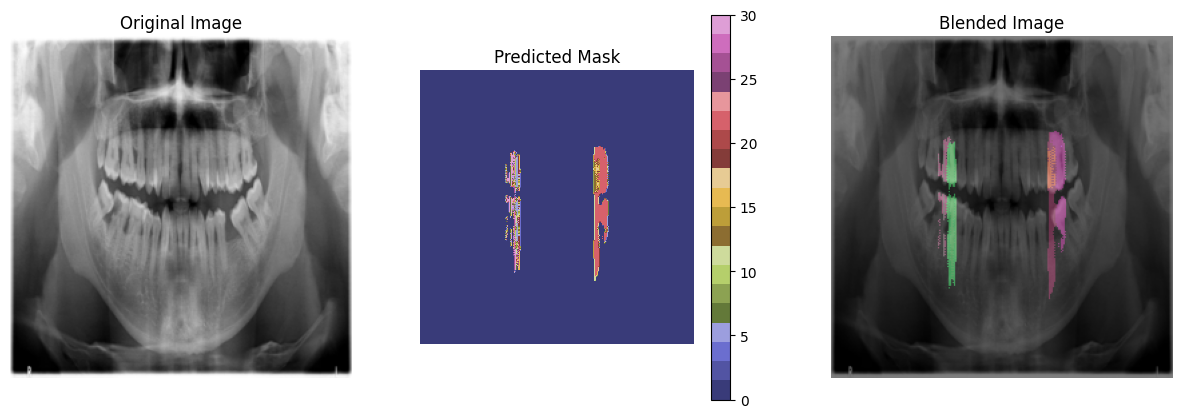

In [80]:

# Example usage:


model_path = "drive/MyDrive/training_data/quadrant_enumeration/explore_unet.pth"
image_path = "drive/MyDrive/training_data/quadrant_enumeration/xrays_2048_1024/train_0.png"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = UNet(in_channels=1, out_channels=33)  # Adjust num_classes as needed
model.load_state_dict(torch.load(model_path))
model.to(device)

evaluate_and_visualize(model, image_path, device)

